# SIMEX notebook for wavefront propagation using the SimEx Calculator "WavePropagator".

In this notebook, we will demonstrate how to propagate a simple Gaussian wavefront between two planes through vacuum. This is the simplest case of coherent wavefront propagation.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Import all SimEx modules
from SimEx.Calculators.WavePropagator import WavePropagator
from SimEx.Calculators.GaussianPhotonSource import GaussianPhotonSource
from SimEx.Parameters.WavePropagatorParameters import WavePropagatorParameters
from SimEx.Parameters.GaussWavefrontParameters import GaussWavefrontParameters

from SimEx.Utilities.Units import electronvolt, meter, joule, radian
import numpy

initializing ocelot...


### Setup the initial wavefront
We first create a wavefront with a Gaussian intensity distribution. To this end, we use the `GaussianPhotonSource` Calculator and it's corresponding parameter class, the `GaussWavefrontParameters`. Looking up the documentation of these two classes gives us the information needed to create the instances:

We first describe the wavefront parameters which will then be used to create the wavefront itself:

In [3]:
wavefront_parameters = GaussWavefrontParameters(photon_energy=8.0e3*electronvolt,
                                                photon_energy_relative_bandwidth=1e-3,
                                                beam_diameter_fwhm=1.0e-4*meter,
                                                pulse_energy=2.0e-6*joule,
                                                number_of_transverse_grid_points=400,
                                                number_of_time_slices=30,
                                                z = 1*meter
                                                )

Now, we use the just created `wavefront_parameters` to initialize the Photon Source.

In [4]:
photon_source_8kev = GaussianPhotonSource(wavefront_parameters, input_path="/dev/null", output_path="initial_wavefront.h5")

Let's calculate the initial wavefront and visualize it:

In [5]:
wavefront_parameters = GaussWavefrontParameters(photon_energy=6.0e3*electronvolt,
                                                photon_energy_relative_bandwidth=1e-3,
                                                beam_diameter_fwhm=1.0e-4*meter,
                                                pulse_energy=2.0e-6*joule,
                                                number_of_transverse_grid_points=400,
                                                number_of_time_slices=30,
                                                z = 1*meter
                                                )

Now, we use the just created `wavefront_parameters` to initialize the Photon Source.

In [6]:
photon_source_6kev = GaussianPhotonSource(wavefront_parameters, input_path="/dev/null", output_path="initial_wavefront.h5")

In [7]:
photon_source_8kev.backengine()
photon_source_6kev.backengine()

beam waist radius from divergence angle = 8.493e-05
beam waist radius from fwhm = 8.493e-05
beam waist radius from divergence angle = 8.493e-05
beam waist radius from fwhm = 8.493e-05


We can retrieve the wavefront data from the calculator:

In [8]:
wavefront_8kev = photon_source_8kev.data
wavefront_6kev = photon_source_6kev.data

Let's visualize the wavefront using the WPG utilities.

In [9]:
from wpg import wpg_uti_wf as wpg_utils
from wpg import Beamline, optical_elements, srwlib

Plot the power as a function of time integrated over the transverse dimensions

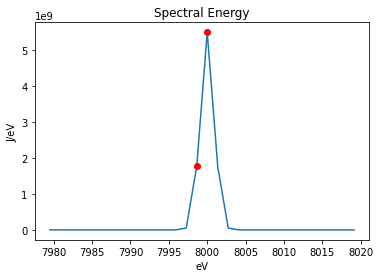

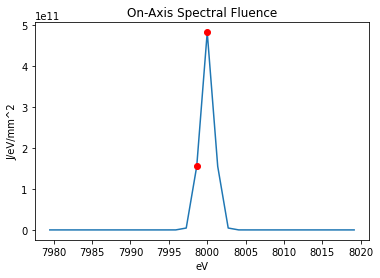

number of meaningful slices: 2


3629883904.0

In [10]:
srwlib.srwl.SetRepresElecField(wavefront_8kev._srwl_wf, 'f')
wpg_utils.integral_intensity(wavefront_8kev)

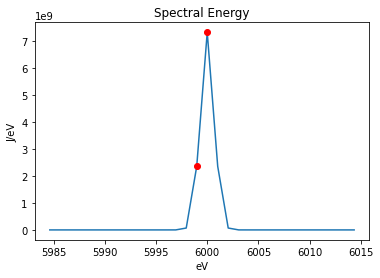

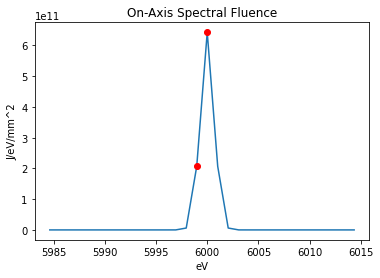

number of meaningful slices: 2


4839844864.0

In [11]:
srwlib.srwl.SetRepresElecField(wavefront_6kev._srwl_wf, 'f')
wpg_utils.integral_intensity(wavefront_6kev)

Plot the power spectrum

In [12]:
import wpg

Ok, we're happy with our initial wavefront and will now proceed to setup the beamline. Our beamline will consist just of a stretch of vacuum over 10 m distance.

## Estimate the beam size after 100 m propagation through empty space
Before we launch the numerical propagation machinery, let's estimate the beam size to be expected after propagating through 10 m of vacuum. 

The beam size (rms width of the E-field distribution, or distance from beam axis where intensity drops to $1/e^2$ of its on-axis value) at a distance $z$ from the wais is given by the expression

$ w(z) = w_0 \sqrt{1 + \left(\frac{z}{R}\right)^2}$, with the Rayleigh length $R = \frac{\pi w_0^2}{\lambda}$, $\lambda$ is the central wavelength of the laser (ca,. 0.15 nm at 8 keV, 0.21 nm at 6 keV.)

Our Gaussian source distribution has a FWHM of $10^{-4} m$. The FWHM and the beam waist radius as defined above are related to each other through $\mathrm{FWHM}(z) = \sqrt{2 \ln 2} w(z) \simeq 1.177 w(z)$


Beam waist at z=0: $w_0 = 100\,\mathrm{\mu m} / 1.177 \simeq 84.9\,\mathrm{\mu m}$.  
The Rayleigh length for our Gaussian beam (8 keV) is $R = \frac{\pi w_0^2}{0.15 \mathrm{nm}} \simeq 151\,\mathrm{m}$, (6 keV) is $R = \frac{\pi w_0^2}{0.21 \mathrm{nm}} \simeq 108\,\mathrm{m}$.

At $z=100\,\mathrm{m}$, we therefore expect a FWHM of $100\,\mu\mathrm{m}\cdot\sqrt{1.+\left(100/151\right)^2} \simeq 119.9 \mu\mathrm{m}$ (8 keV), $100\,\mu\mathrm{m}\cdot\sqrt{1.+\left(100/108\right)^2} \simeq 136.3 \mu\mathrm{m}$ (6 keV).

For numerical reasons, we have to set the radius of curvature to a finite value. Here we choose to set it to a value corresponding approximately to a distance of 1 m from the source position, $z = 1\,\mathrm{m}$.

The radius of curvature $R_{cur}(z)=z\left[{1+{\left({\frac {R}{z}}\right)}^{2}}\right]$

In [13]:
wavefront_8kev.params.Rx = wavefront_8kev.params.Ry = 150**2 # 8 keV
wavefront_6kev.params.Rx = wavefront_6kev.params.Ry = 108**2 # 6 keV

## Setup the beamline

In [14]:
from wpg import Beamline, optical_elements, srwlib
from wpg.useful_code.wfrutils import propagate_wavefront

In [15]:
beamline = Beamline()

In [16]:
free_space = optical_elements.Drift(_L=100, _treat=1)

In [17]:
free_space_propagation_parameters = optical_elements.Use_PP(semi_analytical_treatment=1)

In [18]:
beamline.append(free_space, free_space_propagation_parameters)

In [19]:
srwlib.srwl.SetRepresElecField(wavefront_8kev._srwl_wf, 'f')
# beamline.propagate(wavefront)
wf_file = 'gaussian_8kev.h5'
propagate_wavefront(wavefront_8kev,beamline,wf_file)
srwlib.srwl.SetRepresElecField(wavefront_8kev._srwl_wf, 't')

Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	L = 100
	treat = 1
	

R-space
nx   400  range_x [-1.3e+00, 1.3e+00] mm
ny   400  range_y [-1.3e+00, 1.3e+00] mm
*****propagating wavefront (with resizing)...
save hdf5: gaussian_8kev.h5
done


R-space
(400,) (400,)
FWHM in x = 1.152e-04 m.
FWHM in y = 1.152e-04 m.


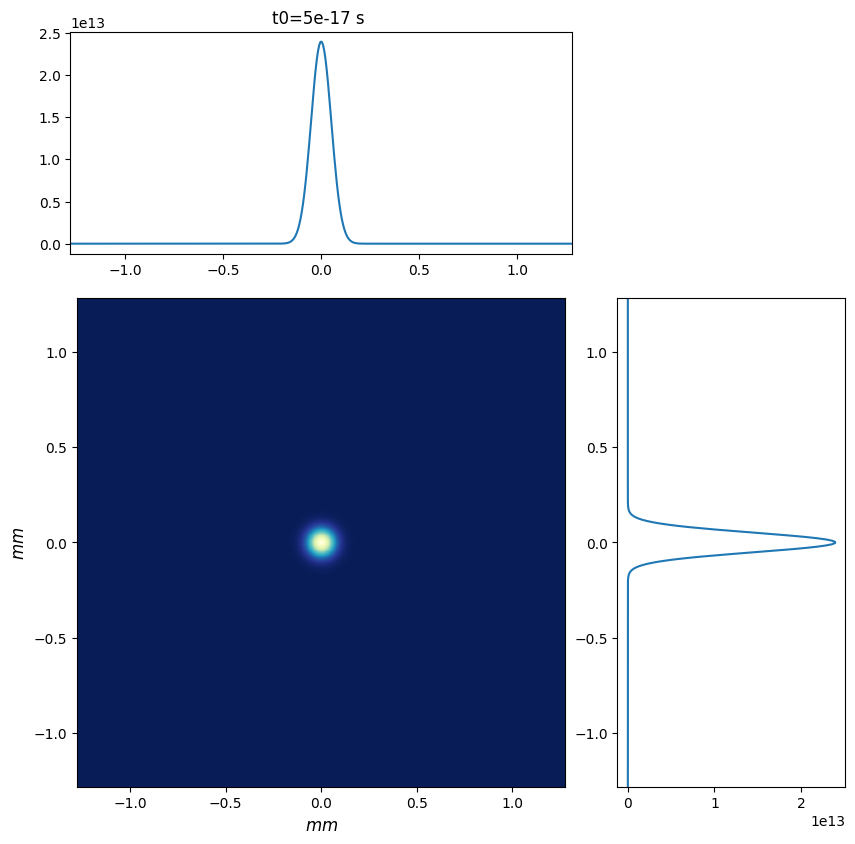

In [20]:
wpg_utils.plot_intensity_map(wavefront_8kev)

The result is $\mathrm{FWHM} = 115.2\,\mathrm{\mu m}$ at $z=100\,\mathrm{m}$. Considering that the FWHM is measured by counting pixels in the intensity profile, this is in rather good agreement with the analytical calculation above.

In [21]:
srwlib.srwl.SetRepresElecField(wavefront_6kev._srwl_wf, 'f')
# beamline.propagate(wavefront)
wf_file = 'gaussian_6kev.h5'
propagate_wavefront(wavefront_6kev,beamline,wf_file)
srwlib.srwl.SetRepresElecField(wavefront_6kev._srwl_wf, 't')

Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	L = 100
	treat = 1
	

R-space
nx   400  range_x [-1.3e+00, 1.3e+00] mm
ny   400  range_y [-1.3e+00, 1.3e+00] mm
*****propagating wavefront (with resizing)...
save hdf5: gaussian_6kev.h5
done


R-space
(400,) (400,)
FWHM in x = 1.413e-04 m.
FWHM in y = 1.413e-04 m.


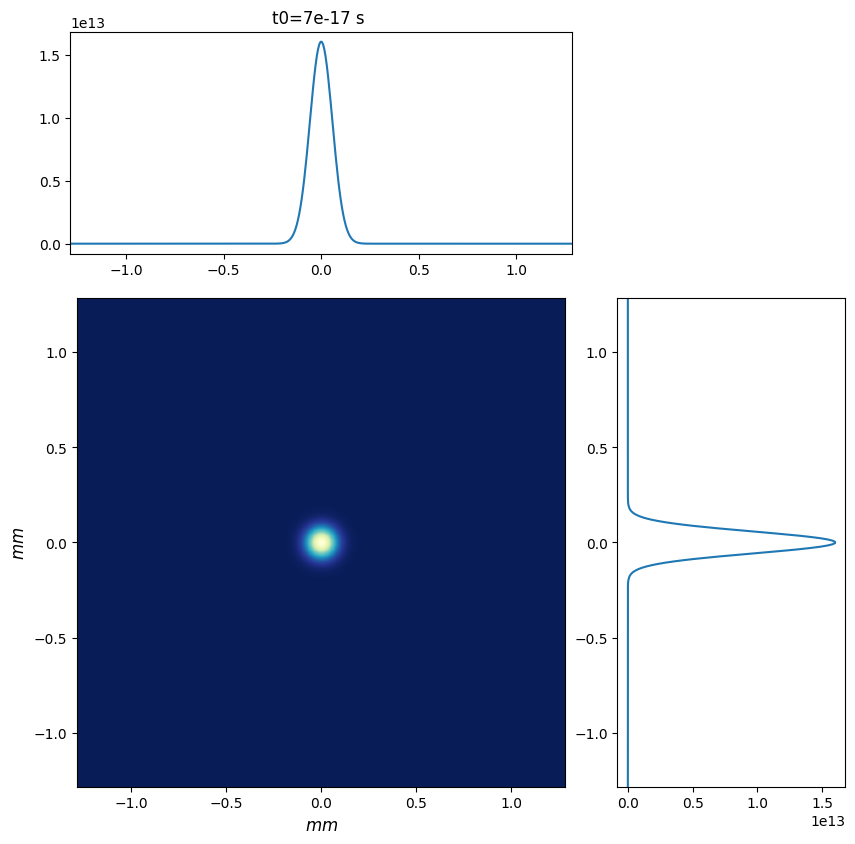

In [22]:
wpg_utils.plot_intensity_map(wavefront_6kev)

The result is $\mathrm{FWHM} = 141.3\,\mathrm{\mu m}$ at $z=100\,\mathrm{m}$. It's also in good agreement with the 6-keV analytical calculation above.